# Killer Sudoku solver using Off Policy Monte Carlo

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
url = 'https://raw.githubusercontent.com/DevinChen02/COGS188_GroupAAA_Project/main/data/ans_data.csv'
url_2 = 'https://raw.githubusercontent.com/DevinChen02/COGS188_GroupAAA_Project/main/data/killer_data.csv'

ans_data   = pd.read_csv(url)
killer_data  = pd.read_csv(url_2)

In [23]:
ans_data.head()

,index,content
0,2_0,"[[1, 2, 3, 4, 5, 6, 7, 8, 9],[5, 7, 8, 1, 3, 9..."
1,2_1,"[[1, 2, 3, 4, 5, 6, 7, 8, 9],[5, 7, 8, 9, 1, 3..."
2,2_10,"[[1, 2, 3, 4, 5, 6, 7, 8, 9],[9, 8, 7, 1, 3, 2..."
3,2_100,"[[1, 2, 3, 4, 5, 6, 7, 8, 9],[6, 8, 9, 7, 1, 3..."
4,2_1000,"[[1, 2, 3, 4, 5, 6, 7, 8, 9],[4, 9, 6, 2, 8, 7..."


In [24]:
killer_data.head()

,index,content
0,2_0,"[[11, [(0, 5), (0, 4)]], [10, [(6, 8), (7, 8)]..."
1,2_1,"[[14, [(8, 1), (8, 0)]], [11, [(2, 5), (1, 5)]..."
2,2_10,"[[12, [(2, 6), (2, 5)]], [10, [(3, 4), (4, 4)]..."
3,2_100,"[[8, [(7, 4), (7, 5)]], [11, [(3, 4), (4, 4)]]..."
4,2_1000,"[[8, [(5, 2), (5, 1)]], [15, [(7, 3), (7, 4)]]..."


## Method: Off-policy Monte Carlo 

#### Pick a random killer sudoku puzzle

In [60]:
import numpy as np
import random
import matplotlib.pyplot as plt
import ast

random_index = np.random.choice(killer_data.index)
random_killer_sudoku = ast.literal_eval(killer_data.loc[random_index, 'content'])
corresponding_ans = ast.literal_eval(ans_data.loc[random_index, 'content'])

print("Randomly picked killer sudoku puzzle:", random_killer_sudoku)
print("Corresponding solution:", corresponding_ans)

Randomly picked killer sudoku puzzle: [[28, [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0)]], [25, [(7, 8), (8, 8), (8, 7), (7, 7), (6, 7)]], [24, [(4, 4), (4, 5), (5, 5), (5, 4), (6, 4)]], [24, [(5, 3), (6, 3), (6, 2), (6, 1), (6, 0)]], [24, [(0, 1), (0, 2), (1, 2), (1, 1), (2, 1)]], [14, [(5, 7), (5, 6), (4, 6)]], [21, [(8, 3), (7, 3), (7, 4)]], [7, [(2, 6), (2, 7)]], [8, [(8, 4), (8, 5), (8, 6)]], [21, [(3, 1), (3, 2), (4, 2), (5, 2), (5, 1)]], [7, [(4, 1)]], [20, [(0, 5), (0, 4), (1, 4), (1, 3)]], [20, [(6, 6), (7, 6), (7, 5), (6, 5)]], [22, [(0, 7), (0, 6), (1, 6), (1, 7)]], [11, [(1, 8), (0, 8)]], [12, [(4, 3), (3, 3), (2, 3)]], [9, [(2, 2)]], [28, [(1, 5), (2, 5), (2, 4), (3, 4), (3, 5)]], [10, [(3, 8), (4, 8), (5, 8)]], [16, [(3, 7), (3, 6)]], [1, [(0, 0)]], [5, [(7, 1), (7, 0)]], [27, [(7, 2), (8, 2), (8, 1), (8, 0)]], [5, [(4, 7)]], [4, [(0, 3)]], [7, [(6, 8)]], [5, [(2, 8)]]]
Corresponding solution: [[1, 2, 3, 4, 5, 6, 7, 8, 9], [7, 5, 6, 1, 8, 9, 3, 4, 2], [4, 8, 9, 7, 2, 3, 1, 6,

#### Set up the Killer Sudoku environment

To set up the environment that's best suited to be solved by Monte Carlo method, we set up the environments in the following ways: 

Action function `is_valid_action(self, row, col, num)`: The valid actions the agent can take are based on the killer sudoku rules: the agent can put any number from 1 to 9 in each cell, each row/column/box/cage should not have duplicate numbers, and the cells in each cage should add up to the corresponding cage sum specified in the puzzle constraint.

Reward function `calculate_reward(self)`: When the puzzle is solved, we set the reward +100. Since killer sudoku can be seen as a puzzle consisting of multiple small puzzles, we have an `evaluate_partial_completions(self)` function to add some reward if the agent can solve parts of the puzzle: if any row/column/box/cage constraint is satisfied, reward + 5. In addition to rewards, we also have a function `evaluate_penalties(self)` to penalize the agent if it fails to satisfy any row/column/box/cage constraint (reward -10).

Function `display_initial_board(self)` is used to display the initial board (should be all 0, meaning the grid is empty at the beginning). Function `visualize_cages(self)` is used to visualize the cage constraints of the selected puzzle.

In [61]:
class KillerSudokuEnv:
    def __init__(self, constraints):
        self.grid = np.zeros((9, 9), dtype=int)
        self.constraints = constraints
        self.visited_states = []
        self.rewards = []
    
    def reset(self):
        self.grid.fill(0)
        self.visited_states = []
        self.rewards = []
        return self.grid
    
    def step(self, action):
        row, col, num = action
        if self.is_valid_action(row, col, num):
            self.grid[row, col] = num
            self.visited_states.append((row, col, num))
            
            reward = self.calculate_reward()
            self.rewards.append(reward)
            
            done = self.is_done()
            return self.grid, reward, done
        else:
            return self.grid, -10, True  # Penalize invalid action and terminate episode
    
    def is_valid_action(self, row, col, num):
        # Check row
        if num in self.grid[row, :]:
            return False
        # Check column
        if num in self.grid[:, col]:
            return False
        # Check 3x3 box
        box_start_row, box_start_col = 3 * (row // 3), 3 * (col // 3)
        if num in self.grid[box_start_row:box_start_row+3, box_start_col:box_start_col+3]:
            return False
        # Check cage constraints
        for total, cells in self.constraints:
            if (row, col) in cells:
                sum_cells = sum(self.grid[r, c] for r, c in cells if (r, c) != (row, col))
                if sum_cells + num > total:
                    return False
        return True
    
    def calculate_reward(self):
        reward = 0
        # Reward for fully solving the puzzle
        if self.is_done():
            reward += 100
        
        # Partial rewards for filling rows, columns, boxes, and cages correctly
        reward += self.evaluate_partial_completions()
        
        # Penalize based on row, column, box, and cage constraints
        reward -= self.evaluate_penalties()
        
        return reward
    
    def evaluate_partial_completions(self):
        reward = 0
        for i in range(9):
            if len(set(self.grid[i, :])) == 9:
                reward += 5  # Reward for completing a row
            if len(set(self.grid[:, i])) == 9:
                reward += 5  # Reward for completing a column
        for box_start_row in range(0, 9, 3):
            for box_start_col in range(0, 9, 3):
                if len(set(self.grid[box_start_row:box_start_row+3, box_start_col:box_start_col+3].flatten())) == 9:
                    reward += 5  # Reward for completing a box
        for total, cells in self.constraints:
            if sum(self.grid[r, c] for r, c in cells) == total:
                reward += 5  # Reward for satisfying the cage constraint
        return reward
    
    def evaluate_penalties(self):
        penalty = 0
        # Penalize incomplete rows, columns, and boxes
        penalty += self.evaluate_rows()
        penalty += self.evaluate_columns()
        penalty += self.evaluate_boxes()
        penalty += self.evaluate_cages()
        return penalty
    
    def evaluate_rows(self):
        penalty = 0
        for row in range(9):
            if not self.is_valid_unit(self.grid[row, :]):
                penalty += 10
        return penalty
    
    def evaluate_columns(self):
        penalty = 0
        for col in range(9):
            if not self.is_valid_unit(self.grid[:, col]):
                penalty += 10
        return penalty
    
    def evaluate_boxes(self):
        penalty = 0
        for i in range(0, 9, 3):
            for j in range(0, 9, 3):
                if not self.is_valid_unit(self.grid[i:i+3, j:j+3].flatten()):
                    penalty += 10
        return penalty
    
    def evaluate_cages(self):
        penalty = 0
        for total, cells in self.constraints:
            sum_cells = sum(self.grid[row, col] for row, col in cells)
            if sum_cells != total:
                penalty += 10
        return penalty
    
    def is_valid_unit(self, unit):
        unit = unit[unit != 0]  # Remove zeros
        return len(unit) == len(set(unit))
    
    def is_done(self):
        return np.all(self.grid != 0)
    
    def valid_actions(self):
        actions = []
        for row in range(9):
            for col in range(9):
                if self.grid[row, col] == 0:
                    for num in range(1, 10):
                        if self.is_valid_action(row, col, num):
                            actions.append((row, col, num))
        return actions
    
    def display_initial_board(self):
        print("Initial Game Board:")
        print(self.grid)
    
    def visualize_cages(self):
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.matshow(self.grid, cmap=plt.cm.Blues)
        
        for total, cells in self.constraints:
            for cell in cells:
                row, col = cell
                ax.text(col, row, str(total), va='center', ha='center')
        
        plt.title("Cages Visualization")
        plt.show()

#### Create an environment based on the randomly picked killer sudoku

Note that the initial game board is empty (all 0's).

In the cages visualization, the number in each cell represents the cage sum of the cage where the cell belongs to. For example, the cell (7,7), (7,8), (8,7), (8,8) should add up to 25.

Initial Game Board:
[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


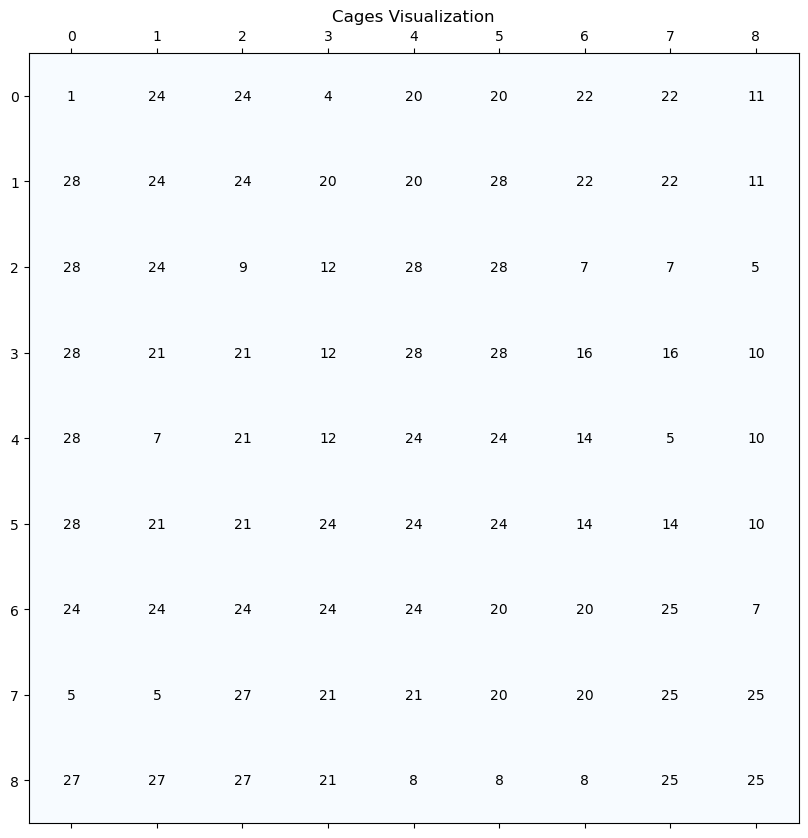

In [62]:
# Create environment
env = KillerSudokuEnv(random_killer_sudoku)
env.display_initial_board()
env.visualize_cages()

#### Set up the Agent using Off-Policy Monte Carlo Control
We implemented an off-policy monte carlo agent with epsilon-greedy strategy for exploration. Weighted importance sampling is used to update the state-action value function and the target policy.

In [63]:
class OffPolicyMC_Agent:
    def __init__(self, env, gamma=0.9, epsilon=0.1):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.returns = {}  # returns for state-action pairs
        self.Q = {}  # State-action value function
        self.C = {}  # Cumulative weights for weighted importance sampling
        self.target_policy = {}  
        self.rewards_per_episode = [] 
        self.accuracies_per_episode = []  
    
    def behavior_policy(self, state):
        valid_actions = self.env.valid_actions()
        if not valid_actions:
            return None
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(valid_actions)
        else:
            state_str = state.tostring()
            if state_str in self.target_policy:
                action_str = self.target_policy[state_str]
                action = tuple(map(int, action_str[1:-1].split(', ')))
                if action in valid_actions:
                    return action
            return random.choice(valid_actions)
    
    def generate_episode(self):
        episode = []
        state = self.env.reset()
        done = False
        
        while not done:
            action = self.behavior_policy(state)
            if action is None:  # No valid actions available
                break
            next_state, reward, done = self.env.step(action)
            episode.append((state.copy(), action, reward))
            state = next_state
        
        return episode
    
    def update_policy(self):
        for state, actions in self.Q.items():
            self.target_policy[state] = max(actions, key=actions.get)
    
    def learn(self, num_episodes, target_solution):
        for episode_num in range(1, num_episodes + 1):
            episode = self.generate_episode()
            G = 0  # Return
            W = 1  # Importance sampling weight
            total_reward = 0
            
            for state, action, reward in reversed(episode):
                G = self.gamma * G + reward
                total_reward += reward
                
                state_str = state.tostring()
                action_str = str(action)
                
                if state_str not in self.Q:
                    self.Q[state_str] = {}
                if action_str not in self.Q[state_str]:
                    self.Q[state_str][action_str] = 0
                
                if (state_str, action_str) not in self.C:
                    self.C[(state_str, action_str)] = 0
                
                self.C[(state_str, action_str)] += W
                self.Q[state_str][action_str] += (W / self.C[(state_str, action_str)]) * (G - self.Q[state_str][action_str])
                
                if state_str not in self.target_policy:
                    self.target_policy[state_str] = action_str
                
                if action_str != self.target_policy[state_str]:
                    break
                
                W *= 1.0  # Probability ratio of target policy to behavior policy (here it's 1 since both are random)
            
            self.update_policy()
            self.rewards_per_episode.append(total_reward)
            
            # Calculate and store accuracy
            accuracy = calculate_accuracy(self.env.grid, target_solution)
            self.accuracies_per_episode.append(accuracy)
            
            if episode_num % 100 == 0:
                avg_accuracy = np.mean(self.accuracies_per_episode[-100:])
                print(f"Episode {episode_num}: Total Reward = {total_reward}, Average Accuracy = {avg_accuracy:.2f}")
        
        return self.env.grid
    
# Accuracy Calculation
def calculate_accuracy(solution, target_solution):
    correct = np.sum(np.array(solution) == np.array(target_solution))
    total = 81  # 9x9 Sudoku grid
    return correct / total

#### Train the agent

We used 16 different combinations of gamma and epsilon values to train our models. The agent with each combination of hyper-parameters was trained for 10000 episodes. 

In [64]:
# Define the target solution
target_solution = corresponding_ans

# Hyper-parameters
gamma_values = [0.8, 0.9, 0.95, 0.99]
epsilon_values = [0.1, 0.2, 0.3, 0.4]
num_episodes = 10000

# Record results
results = []

for gamma in gamma_values:
    for epsilon in epsilon_values:
        print(f"Testing gamma = {gamma}, epsilon = {epsilon}")
        agent = OffPolicyMC_Agent(env, gamma=gamma, epsilon=epsilon)
        final_grid = agent.learn(num_episodes=num_episodes, target_solution=target_solution)
        accuracy = calculate_accuracy(final_grid, target_solution)
        results.append((gamma, epsilon, accuracy, agent.rewards_per_episode, agent.accuracies_per_episode))

Testing gamma = 0.8, epsilon = 0.1


/var/folders/nm/s8l3vdmj2mv2h9294y8vn0yw0000gn/T/ipykernel_1255/3054214953.py:22: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  state_str = state.tostring()
/var/folders/nm/s8l3vdmj2mv2h9294y8vn0yw0000gn/T/ipykernel_1255/3054214953.py:60: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  state_str = state.tostring()


Episode 100: Total Reward = -14365, Average Accuracy = 0.09
Episode 200: Total Reward = -15450, Average Accuracy = 0.09
Episode 300: Total Reward = -15255, Average Accuracy = 0.10
Episode 400: Total Reward = -14295, Average Accuracy = 0.09
Episode 500: Total Reward = -16125, Average Accuracy = 0.10
Episode 600: Total Reward = -15830, Average Accuracy = 0.10
Episode 700: Total Reward = -13870, Average Accuracy = 0.09
Episode 800: Total Reward = -15225, Average Accuracy = 0.10
Episode 900: Total Reward = -14925, Average Accuracy = 0.10
Episode 1000: Total Reward = -14240, Average Accuracy = 0.09
Episode 1100: Total Reward = -16060, Average Accuracy = 0.09
Episode 1200: Total Reward = -15350, Average Accuracy = 0.09
Episode 1300: Total Reward = -15795, Average Accuracy = 0.09
Episode 1400: Total Reward = -13825, Average Accuracy = 0.09
Episode 1500: Total Reward = -15260, Average Accuracy = 0.09
Episode 1600: Total Reward = -14015, Average Accuracy = 0.10
Episode 1700: Total Reward = -154

#### Visualize Total Reward vs. Episode of agents, with different combinations of hyper-parameters

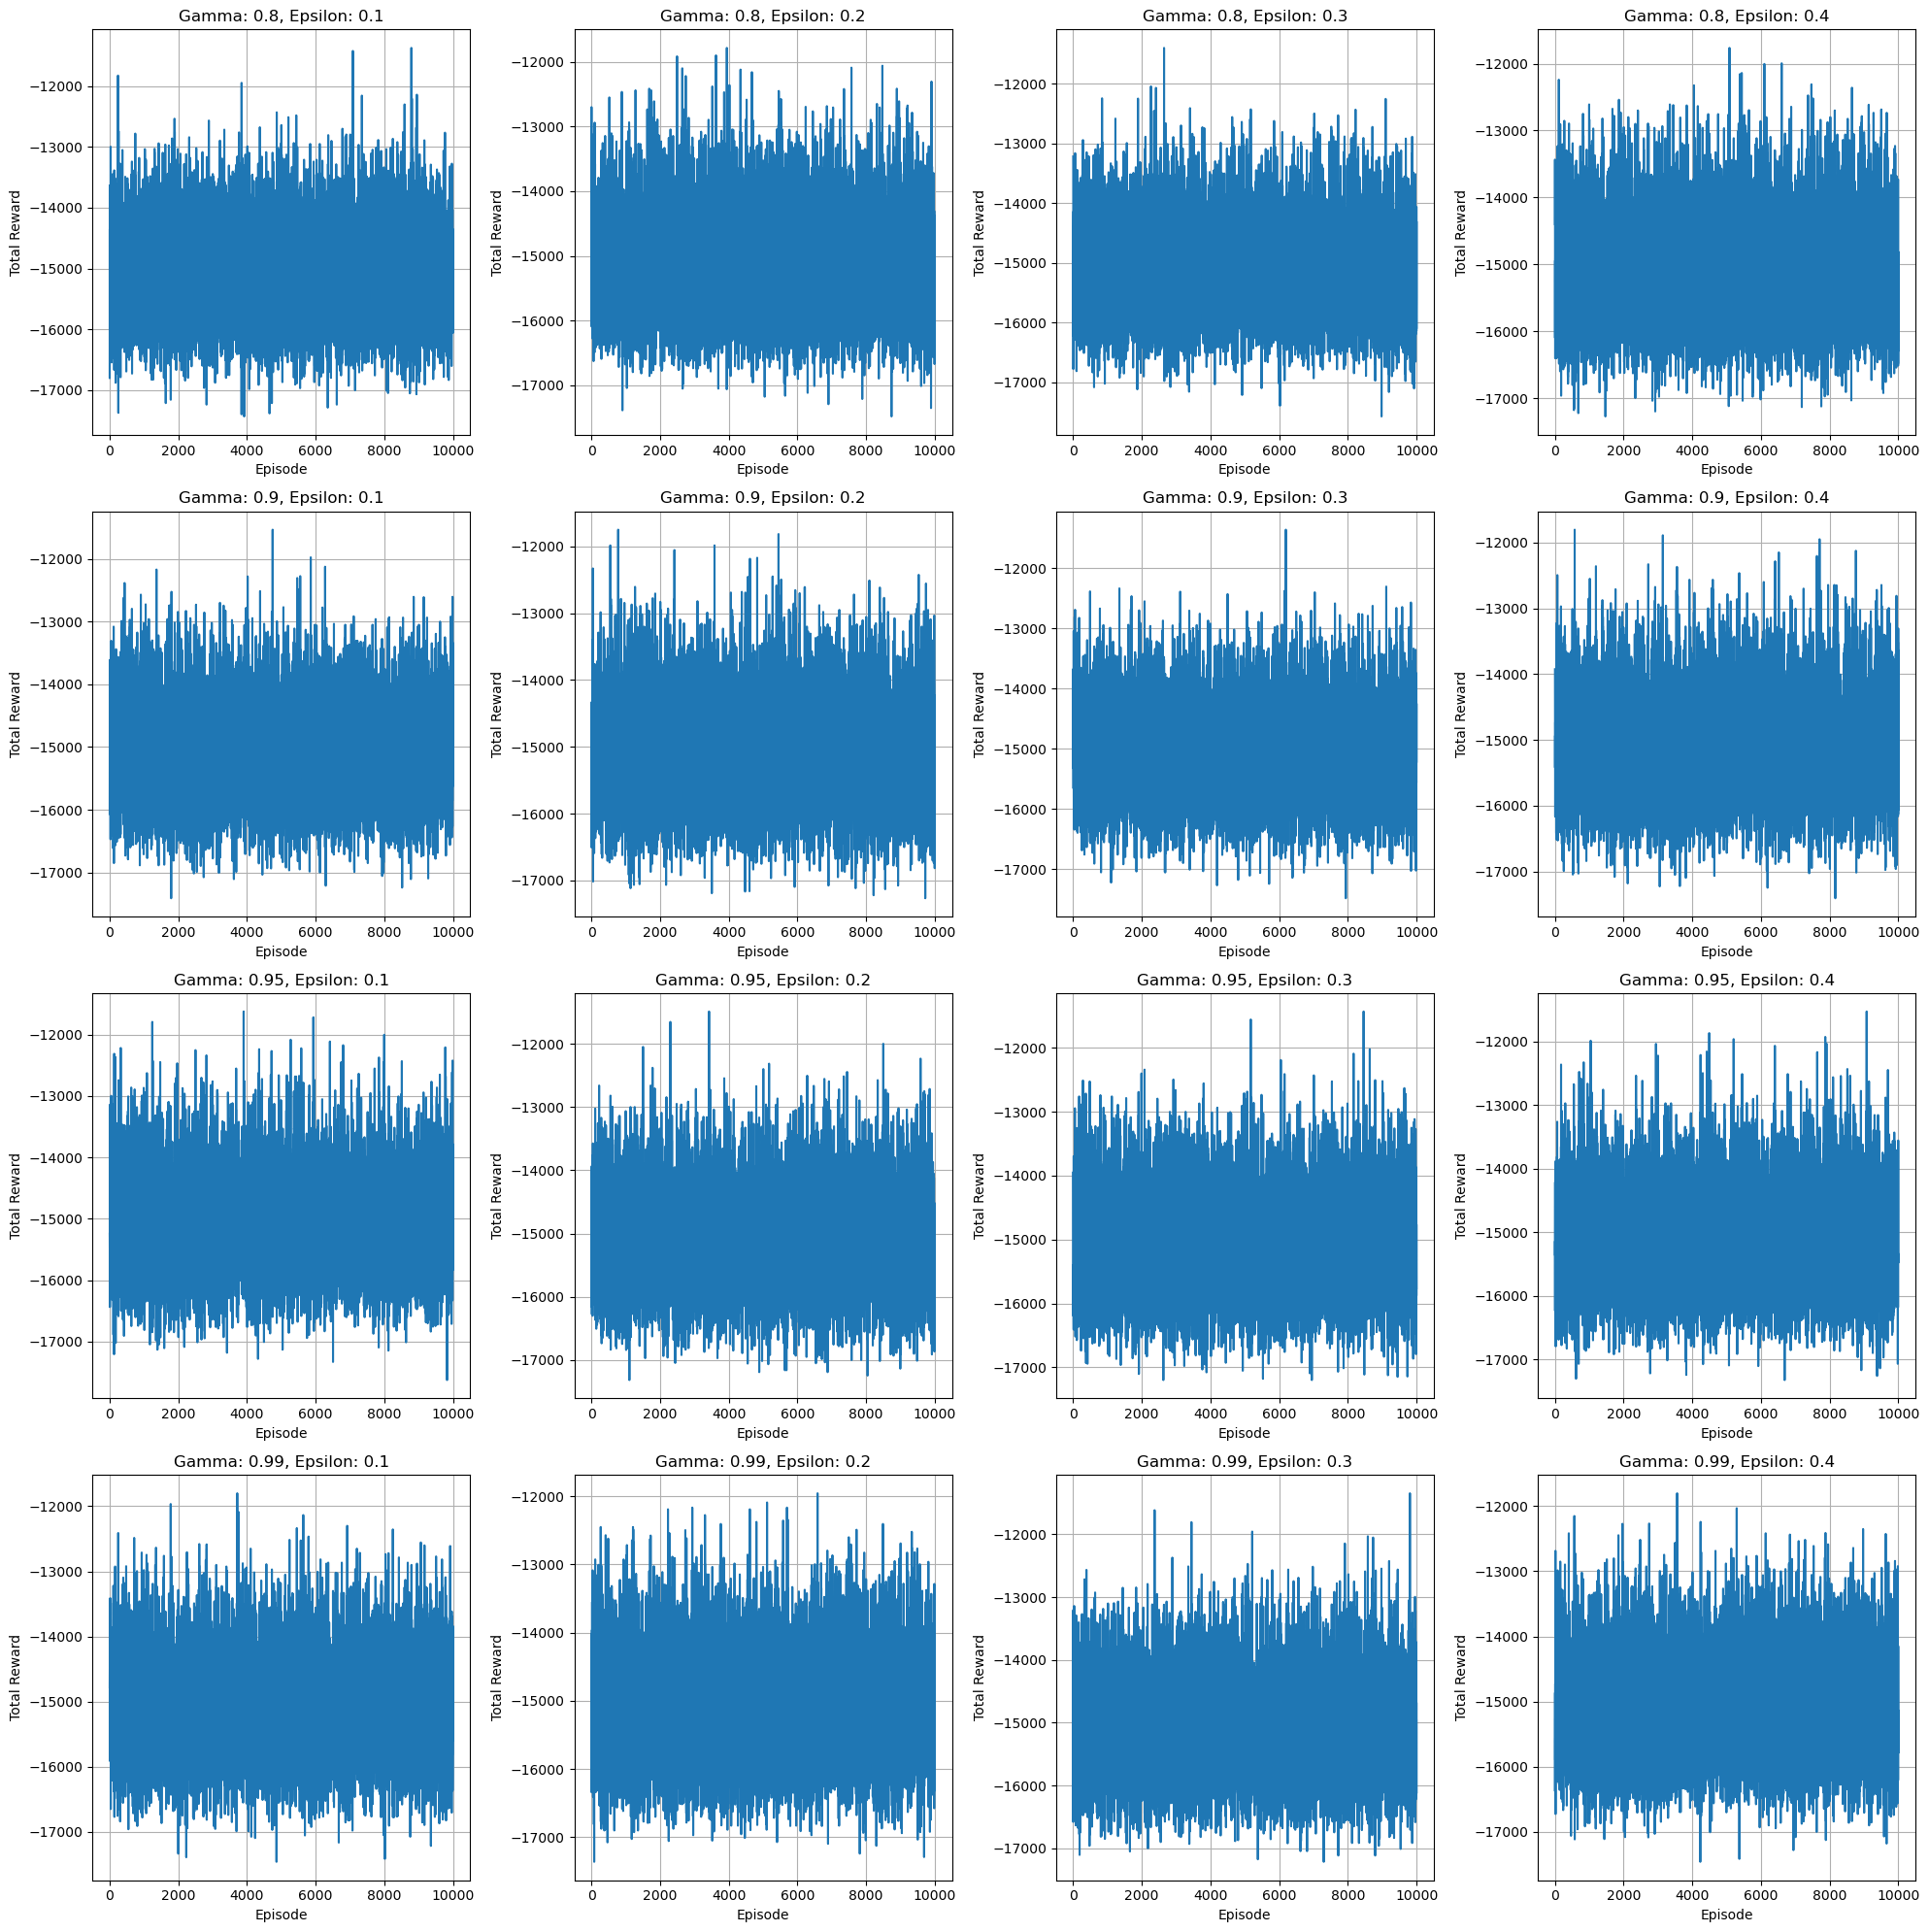

In [65]:
# Plot results
fig, axs = plt.subplots(len(gamma_values), len(epsilon_values), figsize=(20, 20))

for i, gamma in enumerate(gamma_values):
    for j, epsilon in enumerate(epsilon_values):
        rewards_per_episode = [result[3] for result in results if result[0] == gamma and result[1] == epsilon][0]
        axs[i, j].plot(range(num_episodes), rewards_per_episode)
        axs[i, j].set_title(f'Gamma: {gamma}, Epsilon: {epsilon}')
        axs[i, j].set_xlabel('Episode')
        axs[i, j].set_ylabel('Total Reward')
        axs[i, j].grid(True)

plt.tight_layout()
plt.show()

#### Visualize Average Accuracy vs. Episode of agents, with different combinations of hyper-parameters

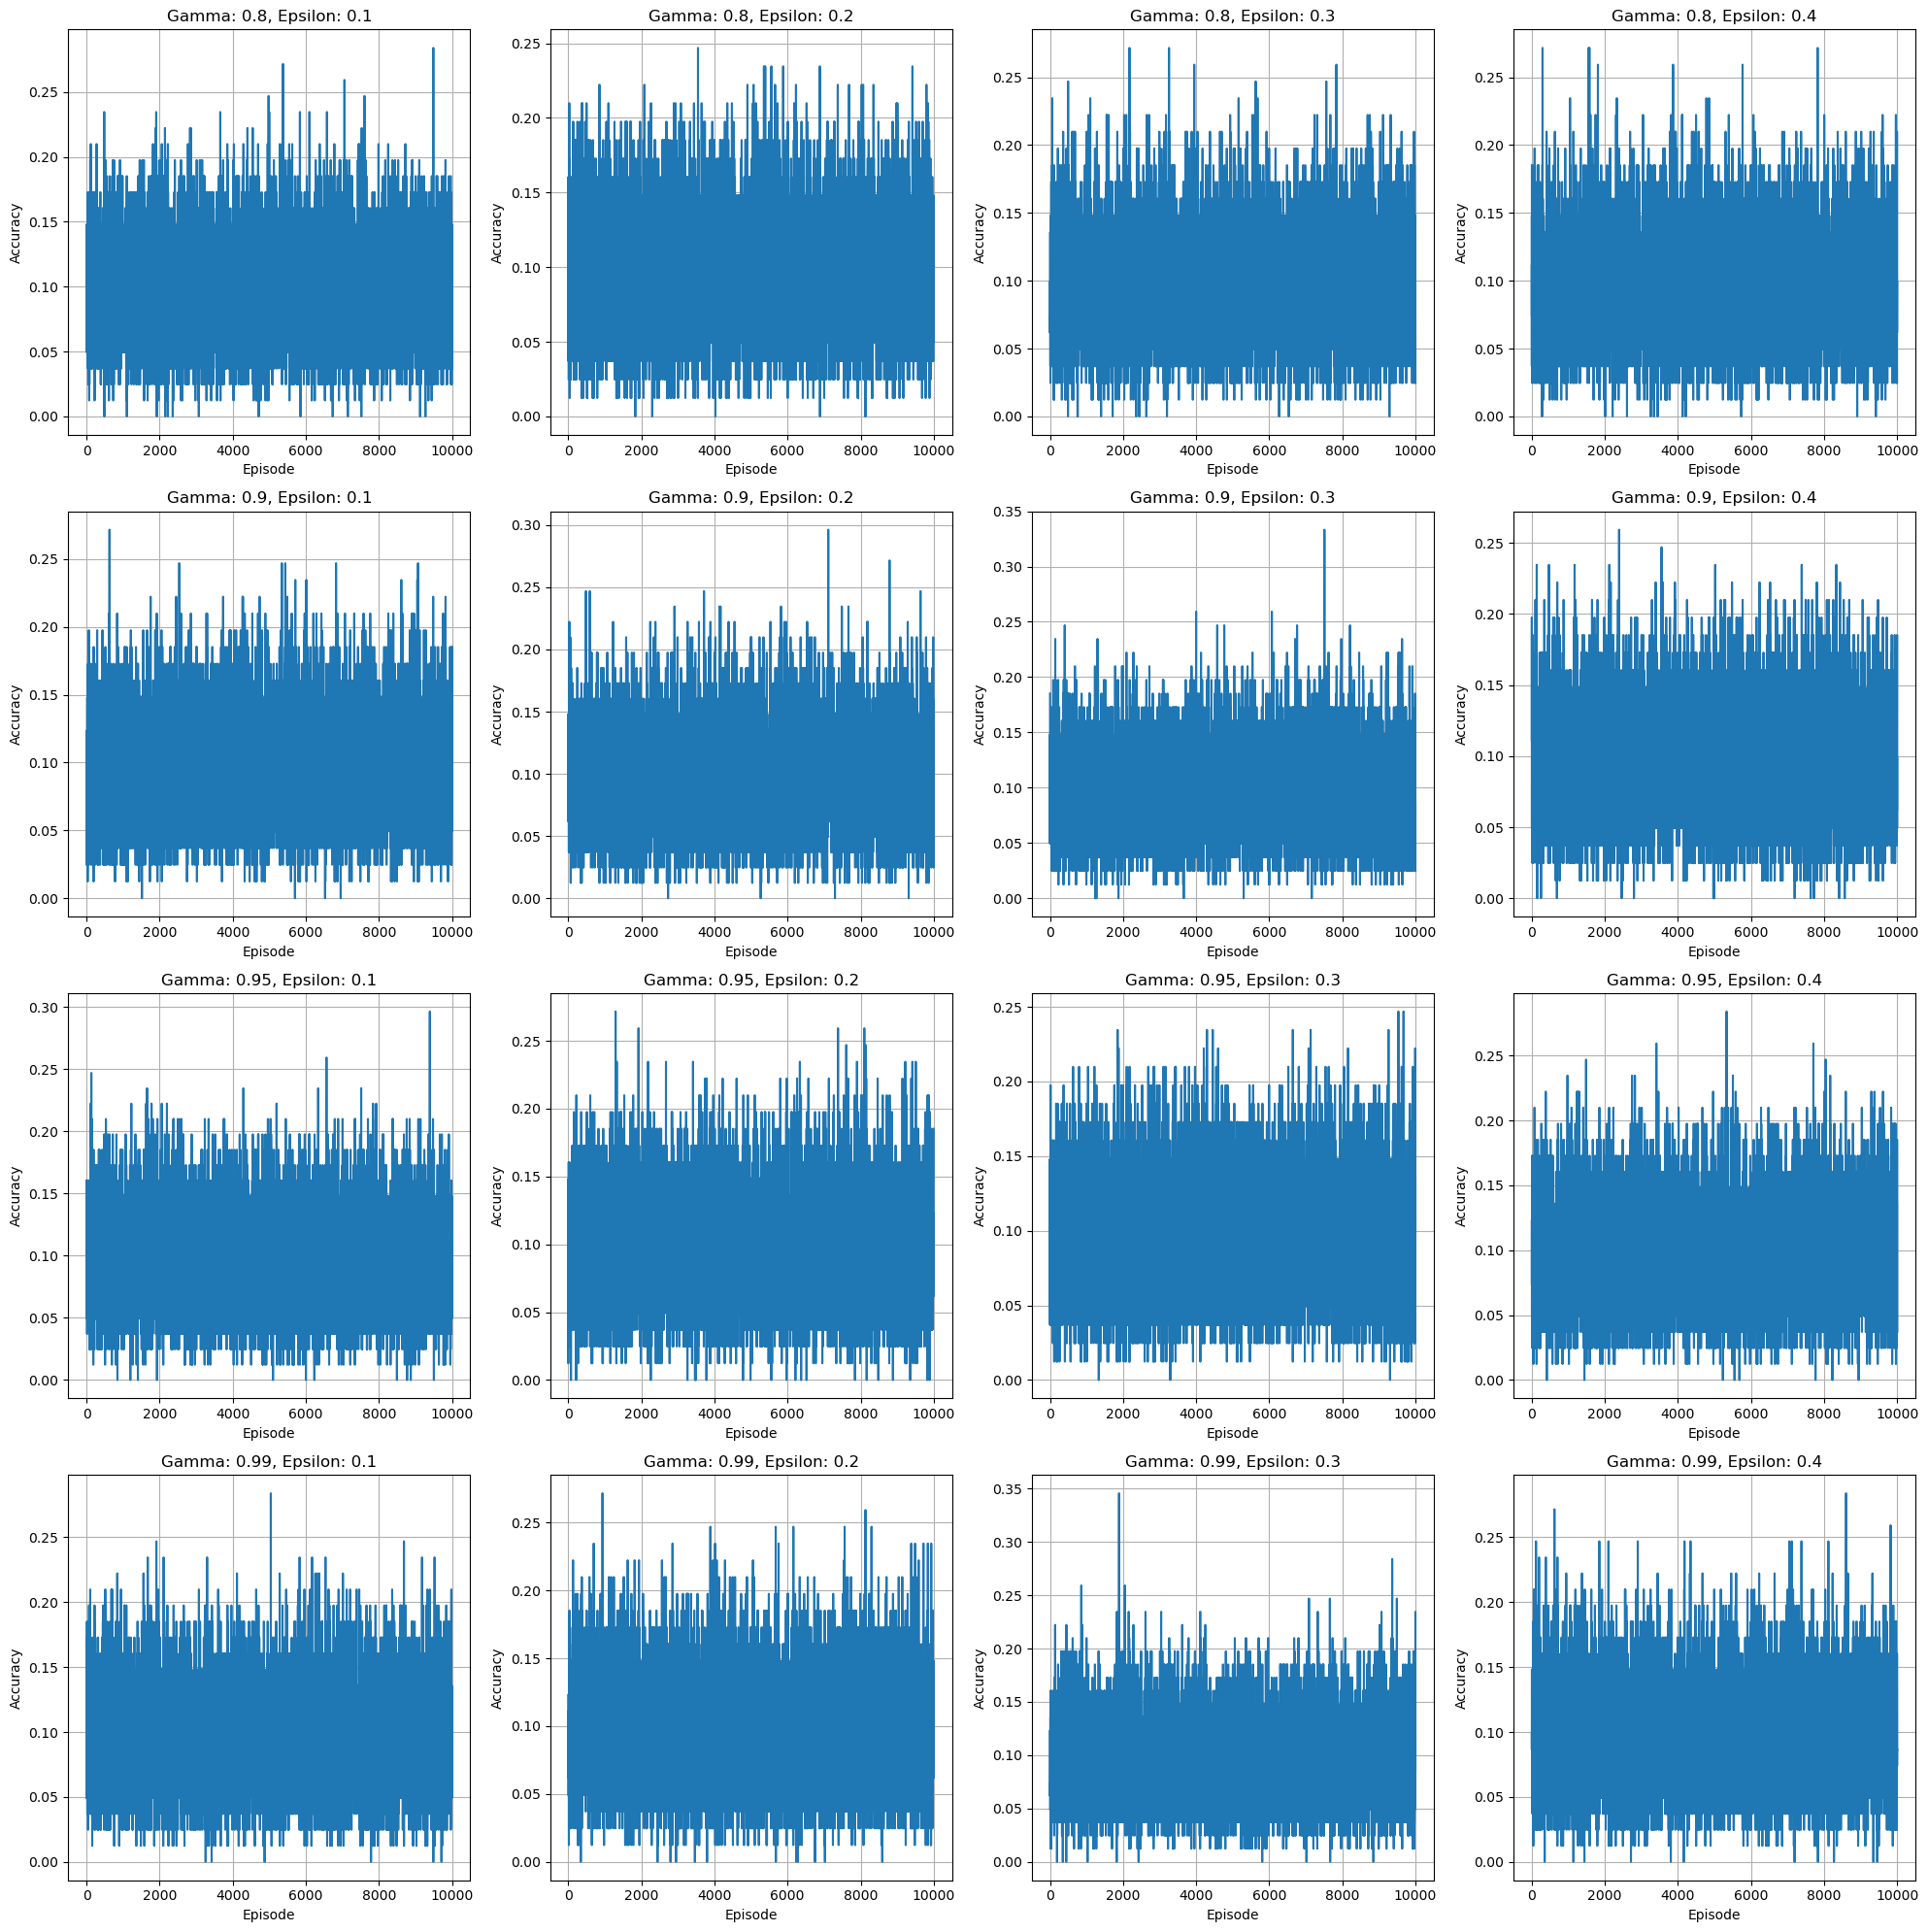

In [66]:
fig, axs = plt.subplots(len(gamma_values), len(epsilon_values), figsize=(20, 20))

for i, gamma in enumerate(gamma_values):
    for j, epsilon in enumerate(epsilon_values):
        accuracies_per_episode = [result[4] for result in results if result[0] == gamma and result[1] == epsilon][0]
        axs[i, j].plot(range(num_episodes), accuracies_per_episode)
        axs[i, j].set_title(f'Gamma: {gamma}, Epsilon: {epsilon}')
        axs[i, j].set_xlabel('Episode')
        axs[i, j].set_ylabel('Accuracy')
        axs[i, j].grid(True)

plt.tight_layout()
plt.show()

#### Based on the average accuracy, we get the following best-performed agent. Let's display the results.

Best Gamma: 0.9, Best Epsilon: 0.1, Best Accuracy: 0.18518518518518517


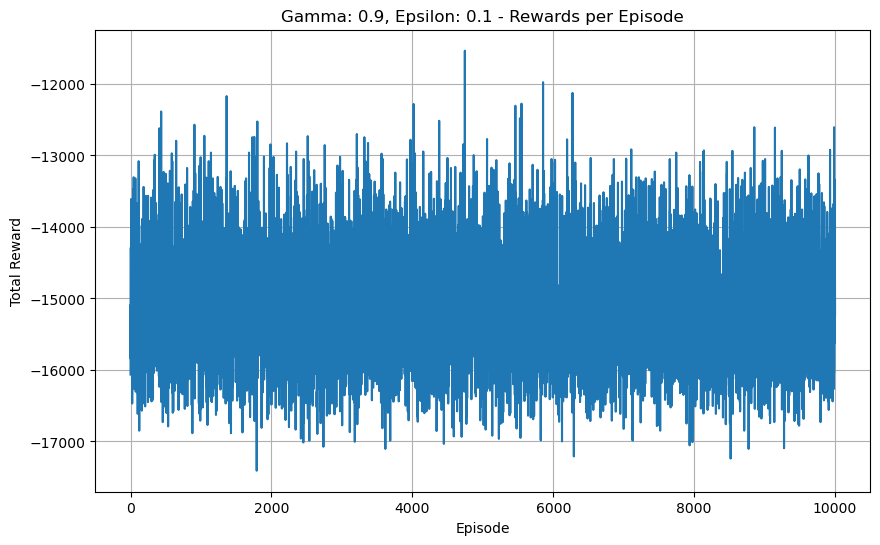

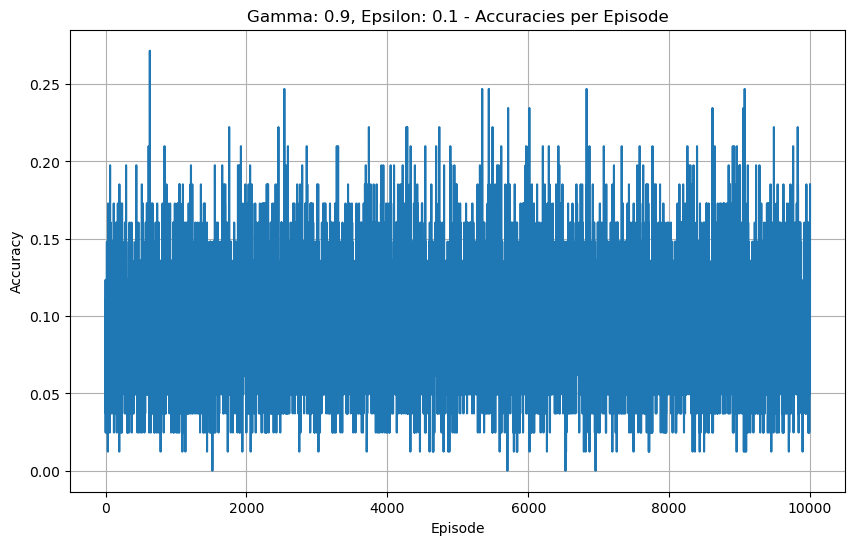

Agent's solution:
[[0 0 6 2 4 0 1 7 9]
 [2 1 4 9 6 8 3 5 0]
 [9 3 8 5 7 1 6 0 0]
 [3 6 1 7 2 5 0 9 4]
 [4 0 9 0 8 6 0 0 3]
 [7 5 0 3 0 9 8 2 1]
 [0 2 3 8 0 4 9 1 5]
 [1 4 5 6 9 2 0 3 8]
 [6 8 7 1 5 3 0 4 2]]


In [67]:
best_result = max(results, key=lambda x: x[2])  # x[2] is the accuracy
best_gamma, best_epsilon, best_accuracy, best_rewards_per_episode, best_accuracies_per_episode = best_result

print(f"Best Gamma: {best_gamma}, Best Epsilon: {best_epsilon}, Best Accuracy: {best_accuracy}")

# Plot the rewards per episode for the best hyper-parameters
plt.figure(figsize=(10, 6))
plt.plot(range(num_episodes), best_rewards_per_episode)
plt.title(f'Gamma: {best_gamma}, Epsilon: {best_epsilon} - Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

# Plot the accuracies per episode for the best hyper-parameters
plt.figure(figsize=(10, 6))
plt.plot(range(num_episodes), best_accuracies_per_episode)
plt.title(f'Gamma: {best_gamma}, Epsilon: {best_epsilon} - Accuracies per Episode')
plt.xlabel('Episode')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Print the solution obtained by the best agent
print("Agent's solution:")
print(env.grid)


Note that for the best-performed agent, the best accuracy was about 0.19 only. 